# Deep CNN Image Classifier 

In [31]:
!pip install tensorflow opencv-python matplotlib

In [32]:
import tensorflow as tf
import os

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.confif.experimental.set_memory_growth(gpu, True)

# 1.2 Remove dodgy images

In [34]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

In [35]:
directory = "data"

In [36]:
extensions = ["jpeg", "jpg", "png", "bmp"]

In [37]:
for image_classes in os.listdir(directory):
    for image in os.listdir(os.path.join(directory, image_classes)):
        path_image = os.path.join(directory, image_classes, image)
        try:
            individual_image = cv2.imread(path_image)
            tip = imghdr.what(path_image)
            if tip not in extensions:
                print("Image not in extensions list")
                os.remove(path_image)
        except Exception as e:
            print("Issue with image")

# 2. Load Data

In [38]:
data = tf.keras.utils.image_dataset_from_directory("data") #building a data pipeline

Found 5232 files belonging to 2 classes.


In [39]:
iterator = data.as_numpy_iterator() # loop through the data pipeline

In [40]:
iterator

In [41]:
#Re-execute to get a new batch of images
batch = iterator.next() 

In [42]:
batch[0].shape

(32, 256, 256, 3)

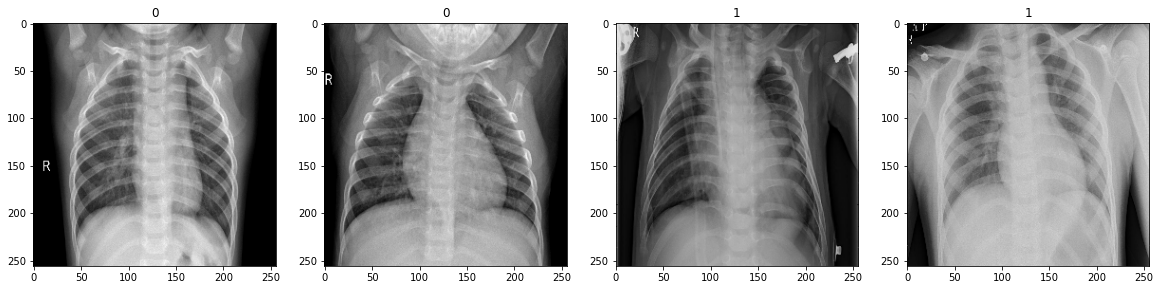

In [43]:
figure, axis = plt.subplots(ncols = 4, figsize = (20, 20))
for index, image in enumerate(batch[0][:4]):
    axis[index].imshow(image.astype(int))
    axis[index].title.set_text(batch[1][index])

# 3. Preprosessing Data

### 2.1 Scale Data

In [44]:
data = data.map(lambda x, y : (x/255, y))

In [45]:
batch = data.as_numpy_iterator().next()

In [46]:
batch[0].max()

1.0

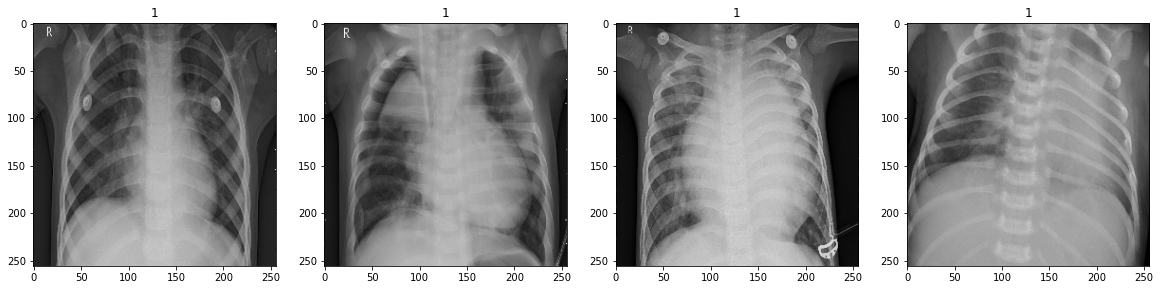

In [47]:
figure, axis = plt.subplots(ncols = 4, figsize = (20, 20))
for index, image in enumerate(batch[0][:4]):
    axis[index].imshow(image)
    axis[index].title.set_text(batch[1][index])

### 2.2 Split Data into Training and Testing Partitions

In [48]:
len(data)

164

In [ ]:
train_set = int(len(data)*.7)
validation_set = int(len(data)*.2) +1 #model doesnt see this set used for 
test_set = int(len(data)*.1)+1 #model doesnt see this set until the final evaluation stage 

In [ ]:
train_set + test_set + validation_set

In [ ]:
train = data.take(train_set)
val = data.skip(train_set).take(validation_set)
test = data.skip(train_set+validation_set).take(test_set)

In [ ]:
len(train)

# 4. Deep Learning Model

### 4.1 Building a deep learning model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [54]:
model = Sequential()

In [55]:
# convolution layer with 16 filters each is 3 * 3 pixels it takes a stride of 1 pixel
# We are taking the output and passing it through a function which converts any output that was below 0 to 0 and positive values remain unchanged
model.add(Conv2D(16, (3,3), 1, activation = "relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())
#takes and return the max value from a (2, 2) region

model.add(Conv2D(32, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [56]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

### 3.2 Train

In [58]:
logdir = "logs"

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs = 20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
114/114 [==============================] - 76s 633ms/step - loss: 0.2105 - accuracy: 0.9161 - val_loss: 0.1255 - val_accuracy: 0.9570
Epoch 2/20
114/114 [==============================] - 73s 628ms/step - loss: 0.1519 - accuracy: 0.9380 - val_loss: 0.1512 - val_accuracy: 0.9434
Epoch 3/20
114/114 [==============================] - 73s 632ms/step - loss: 0.0942 - accuracy: 0.9663 - val_loss: 0.1051 - val_accuracy: 0.9600
Epoch 4/20
114/114 [==============================] - 73s 625ms/step - loss: 0.0687 - accuracy: 0.9737 - val_loss: 0.1171 - val_accuracy: 0.9629
Epoch 5/20
114/114 [==============================] - 73s 631ms/step - loss: 0.0518 - accuracy: 0.9800 - val_loss: 0.1038 - val_accuracy: 0.9688
Epoch 6/20
114/114 [==============================] - 73s 626ms/step - loss: 0.0386 - accuracy: 0.9868 - val_loss: 0.1029 - val_accuracy: 0.9668
Epoch 7/20
114/114 [==============================] - 73s 631ms/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.1236 - val_ac

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()